#**Машинное обучение ИБ-2024**

#**Домашнее задание 1.**
#Регрессия, KNN, LinearRegression.

В данной домашней работе мы будем строить модели для предсказания цены квартиры в России. Ниже приведено описание некоторых колонок набора данных.

date - дата публикации объявления

price - цена в рублях

level- этаж, на котором находится квартира

levels - количество этажей в квартире

rooms - количество комнат в квартире. Если значение -1, то квартира считается апартаментами.

area - площадь квартиры.

kitchen_area - площадь кухни.

geo_lat - Latitude

geo_lon - Longitude

building_type - материал застройки. 0 - Don't know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden

#Часть 0. Начало работы

Для начала работы с данными импортируем библиотеки, которые понадобятся в данном задании.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn
import seaborn as sns

Загрузим библиотеку folium для отображения данных на карте по координатам.

In [2]:
!pip install folium

Распакуем наши данные из архива.

Загрузим данные из csv файла в датафрейм.

In [3]:
df = pd.read_csv("input_data.csv", sep=";", encoding="cp1251", low_memory=False)
print(df)

               date     price  level  levels  rooms    area kitchen_area  \
0        01.01.2021   2451300     15      31      1  30.мар            0   
1        01.01.2021   1450000      5       5      1      33            6   
2        01.01.2021  10700000      4      13      3      85           12   
3        01.01.2021   3100000      3       5      3      82            9   
4        01.01.2021   2500000      2       3      1      30            9   
...             ...       ...    ...     ...    ...     ...          ...   
1048570  15.02.2021   1100000      1       5      1      31            6   
1048571  15.02.2021    900000      1       2     -1    34.9         -100   
1048572  15.02.2021   7350000      2      12      3      72           12   
1048573  15.02.2021   2500000      2       5      1      31            6   
1048574  15.02.2021   1560000     12      17      1    36.8            7   

           geo_lat    geo_lon  building_type  object_type  postal_code  \
0        56.7

Отобразим на карте координаты наших построек.

In [4]:
import folium
from IPython.display import display

map_df = df.loc[:1000]

m = folium.Map(location=[55.751244, 37.618423], zoom_start=10)

# Список точек с широтой и долготой
lats = map_df['geo_lat'].loc[:1000]
longs = map_df['geo_lon'].loc[:1000]
# Добавляем точки на карту
for point in zip(lats, longs):
    folium.Marker(location=[point[0], point[1]]).add_to(m)
    
display(m)

# Часть 1. Подготовим данные для обработки моделями машинного обучения.

**0.5 Балл**. География наших наблюдений в наборе данных крайне большая. Однако мы знаем, что стоимость квартир в Москве и Санкт-Петербурге намного выше, чем в среднем по России. Давайте сделаем признаки, который показывают, находится ли квартира в 20 килиметрах от центра Москвы или находится ли квартира в 20 килиметрах от центра Санкт-Петербурга.

Создайте два признака is_Moscow и is_Saint_Peterburg. Для нахождения расстояния по координатам используйте функцию haversine_distance.

In [5]:
def haversine_distance(lat1, lon1, lat2, lon2):

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

# Координаты центров Москвы и СПб
msc_center = (55.755826, 37.617300)
spb_center = (59.939095, 30.315868)

# Вычисляем расстояния
df['dist_to_moscow'] = haversine_distance(
    df['geo_lat'], df['geo_lon'], msc_center[0], msc_center[1]
)

df['dist_to_spb'] = haversine_distance(
    df['geo_lat'], df['geo_lon'], spb_center[0], spb_center[1]
)

# Создаем бинарные признаки
df['is_Moscow'] = (df['dist_to_moscow'] <= 20).astype(int)
df['is_Saint_Peterburg'] = (df['dist_to_spb'] <= 20).astype(int)

# Удаляем временные столбцы с расстояниями (если не нужны)
df = df.drop(['dist_to_moscow', 'dist_to_spb'], axis=1)

print(df[['is_Moscow', 'is_Saint_Peterburg']].value_counts())

is_Moscow  is_Saint_Peterburg
0          0                     883415
1          0                      90771
0          1                      74389
Name: count, dtype: int64


**0.5 Балла**. В нашем наборе данных есть признаки, которые мы теоретически можем использовать, например postal_code, но мы это будем делать в рамках домашней работы очень-очень долго. Поэтому предлагается удалить ненужные признаки из датафрейма.

Удалим geo_lat,	geo_lon,	object_type,	postal_code,	street_id,	id_region,	house_id.

In [6]:
columns_to_drop = ['geo_lat', 'geo_lon', 'object_type', 'postal_code', 'street_id', 'id_region', 'house_id']

# Проверяем какие из этих колонок существуют в датафрейме
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Удаляем сущевствующие колонки
df = df.drop(columns=existing_columns_to_drop)
print(df)

               date     price  level  levels  rooms    area kitchen_area  \
0        01.01.2021   2451300     15      31      1  30.мар            0   
1        01.01.2021   1450000      5       5      1      33            6   
2        01.01.2021  10700000      4      13      3      85           12   
3        01.01.2021   3100000      3       5      3      82            9   
4        01.01.2021   2500000      2       3      1      30            9   
...             ...       ...    ...     ...    ...     ...          ...   
1048570  15.02.2021   1100000      1       5      1      31            6   
1048571  15.02.2021    900000      1       2     -1    34.9         -100   
1048572  15.02.2021   7350000      2      12      3      72           12   
1048573  15.02.2021   2500000      2       5      1      31            6   
1048574  15.02.2021   1560000     12      17      1    36.8            7   

         building_type  is_Moscow  is_Saint_Peterburg  
0                    0         

**0.5 Балл**. Для начала Вам предлагается проанализировать Ваши оставшиеся признаки (колонки) в наборе данных. Какие колонки категориальные? Какие числовые?

Категориальные: (Ваш ответ)

Числовые: (Ваш ответ)

Давайте закодируем категориальные признаки с помощью OneHot-Encoding. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [7]:
"""
Я предположу, что в признаках area, kitchen_areа, допустим, 30.мар нужно извлекать число 30, поэтому реализирую данную функцию.
"""
def simple_convert(value):
    # Если значение уже число - возвращаем как есть
    if value == '-100':
        return float(value)
        
    if isinstance(value, (int, float)):
        return float(value)
    
    # Если строка - извлекаем число из начала
    if isinstance(value, str):
        # Ищем цифры в начале строки
        import re
        match = re.match(r'^(\d+)', value)  # ищем цифры в начале
        if match:
            return float(match.group(1))  # берем первую группу цифр

df['area'] = df['area'].apply(simple_convert)
df['kitchen_area'] = df['kitchen_area'].apply(simple_convert)
print(df)

               date     price  level  levels  rooms  area  kitchen_area  \
0        01.01.2021   2451300     15      31      1  30.0           0.0   
1        01.01.2021   1450000      5       5      1  33.0           6.0   
2        01.01.2021  10700000      4      13      3  85.0          12.0   
3        01.01.2021   3100000      3       5      3  82.0           9.0   
4        01.01.2021   2500000      2       3      1  30.0           9.0   
...             ...       ...    ...     ...    ...   ...           ...   
1048570  15.02.2021   1100000      1       5      1  31.0           6.0   
1048571  15.02.2021    900000      1       2     -1  34.0        -100.0   
1048572  15.02.2021   7350000      2      12      3  72.0          12.0   
1048573  15.02.2021   2500000      2       5      1  31.0           6.0   
1048574  15.02.2021   1560000     12      17      1  36.0           7.0   

         building_type  is_Moscow  is_Saint_Peterburg  
0                    0          0          

In [8]:
"""
Исключим все аномалии, точно не узнаем, но исключим
"""
def remove_anomalies(df):
    df_clean = df.copy()
    
    df_clean['area'] = df_clean['area'].apply(simple_convert)
    df_clean['kitchen_area'] = df_clean['kitchen_area'].apply(simple_convert)
    df_clean['price'] = df_clean['price'].apply(simple_convert)
    df_clean['level'] = pd.to_numeric(df_clean['level'], errors='coerce')
    df_clean['levels'] = pd.to_numeric(df_clean['levels'], errors='coerce')
    
    # Удаляем очевидные аномалии в площади
    df_clean = df_clean[(df_clean['area'] >= 10)]
    df_clean = df_clean[(df_clean['rooms'] >= 1)]
    df_clean = df_clean[(df_clean['kitchen_area'] >= 0)]
    df_clean = df_clean[df_clean['area'] > df_clean['kitchen_area']]
    
    # Удаляем аномалии в цене (если price - целевая переменная)
    df_clean = df_clean[(df_clean['price'] > 100000) & (df_clean['price'] < 200000000)]
    
    # Проверяем этажи
    df_clean = df_clean[df_clean['level'] <= df_clean['levels']]
    
    return df_clean

# Применяем удаление аномалий
df_clean = remove_anomalies(df)
print(df_clean)

               date       price  level  levels  rooms  area  kitchen_area  \
0        01.01.2021   2451300.0     15      31      1  30.0           0.0   
1        01.01.2021   1450000.0      5       5      1  33.0           6.0   
2        01.01.2021  10700000.0      4      13      3  85.0          12.0   
3        01.01.2021   3100000.0      3       5      3  82.0           9.0   
4        01.01.2021   2500000.0      2       3      1  30.0           9.0   
...             ...         ...    ...     ...    ...   ...           ...   
1048569  15.02.2021   4170000.0     10      13      1  58.0          17.0   
1048570  15.02.2021   1100000.0      1       5      1  31.0           6.0   
1048572  15.02.2021   7350000.0      2      12      3  72.0          12.0   
1048573  15.02.2021   2500000.0      2       5      1  31.0           6.0   
1048574  15.02.2021   1560000.0     12      17      1  36.0           7.0   

         building_type  is_Moscow  is_Saint_Peterburg  
0                  

In [9]:
df_clean = df_clean.dropna(subset=['rooms', 'kitchen_area', 'area'])
print(df_clean.dtypes)

date                   object
price                 float64
level                   int64
levels                  int64
rooms                   int64
area                  float64
kitchen_area          float64
building_type           int64
is_Moscow               int64
is_Saint_Peterburg      int64
dtype: object


In [10]:
"""
Категориальные: 1 - Building_type, и нам нужно сводить к бинарному значению на 6 столбец
(материал застройки. 0 - Don't know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden)
Числовые: 5 - level, levels, rooms, area, kitchen_area. Date мы на след. задание удалим и используем другой признак, dates, 
где фиксирует от нашего первого дня до конечного.
Бинарные: is_Moscow, is_Saint_Peterburg and building_type_{N} for N in range(7)
Единственное, что нужно делать - это поменять тип признаков на числовую.
Прежде, надо удалить все аномалии.
""" 

# Price, Kitchen_area and area в числовой формат, так как являются тип object, но по сути числовые
df_clean['area'] = pd.to_numeric(df_clean['area'], errors='coerce')
df_clean['kitchen_area'] = pd.to_numeric(df_clean['kitchen_area'], errors='coerce')
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')

In [11]:
from sklearn.preprocessing import OneHotEncoder
# Списки признаков: числовые и категориальные
categorical_columns = ['building_type']
numerical_columns = ['date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'is_Moscow', 'is_Saint_Peterburg']

# Применим OneHotEncoder только к building_type
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df_clean[categorical_columns])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# Объединим всё в итоговый DataFrame
df_encoded = pd.concat([df_clean[numerical_columns].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

print("Финальный датафрейм:")
print(df_encoded)

Финальный датафрейм:
              date       price  level  levels  rooms  area  kitchen_area  \
0       01.01.2021   2451300.0     15      31      1  30.0           0.0   
1       01.01.2021   1450000.0      5       5      1  33.0           6.0   
2       01.01.2021  10700000.0      4      13      3  85.0          12.0   
3       01.01.2021   3100000.0      3       5      3  82.0           9.0   
4       01.01.2021   2500000.0      2       3      1  30.0           9.0   
...            ...         ...    ...     ...    ...   ...           ...   
862413  15.02.2021   4170000.0     10      13      1  58.0          17.0   
862414  15.02.2021   1100000.0      1       5      1  31.0           6.0   
862415  15.02.2021   7350000.0      2      12      3  72.0          12.0   
862416  15.02.2021   2500000.0      2       5      1  31.0           6.0   
862417  15.02.2021   1560000.0     12      17      1  36.0           7.0   

        is_Moscow  is_Saint_Peterburg  building_type_0  building_t

**0.5 Балл**. Поработаем с числовыми признаками:


1.   Добавьте в ваш датасет два признака: количество дней со дня первого наблюдения (разница между датами объявлений). Возможно, для предсказания цены не так важен этаж, как важно отношение этажа квартиры на количество этажей в доме, добавьте этот признак. После добавления нового признака колонку date можно удалить.
2.   Числовые признаки могут иметь разные порядки. Давайте отнормируем числовые признаки с помощью StandartScaller https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.



In [12]:
# Преобразуем дату в количество дней от минимальной даты
df_encoded['date'] = pd.to_datetime(df_encoded['date'], errors='coerce', dayfirst=True)
first_date = df_encoded['date'].min()
df_encoded['dates'] = (df_encoded['date'] - first_date).dt.days

# Добавляем отношение этажа к общему количеству этажей
df_encoded['floor_ratio'] = df_encoded['level'] / df_encoded['levels'].replace(0, np.nan)

In [13]:
df_encoded = df_encoded.drop('date', axis=1)

In [14]:
print("До StandardScaler:")
print(df_encoded)

До StandardScaler:
             price  level  levels  rooms  area  kitchen_area  is_Moscow  \
0        2451300.0     15      31      1  30.0           0.0          0   
1        1450000.0      5       5      1  33.0           6.0          0   
2       10700000.0      4      13      3  85.0          12.0          0   
3        3100000.0      3       5      3  82.0           9.0          0   
4        2500000.0      2       3      1  30.0           9.0          0   
...            ...    ...     ...    ...   ...           ...        ...   
862413   4170000.0     10      13      1  58.0          17.0          0   
862414   1100000.0      1       5      1  31.0           6.0          0   
862415   7350000.0      2      12      3  72.0          12.0          0   
862416   2500000.0      2       5      1  31.0           6.0          0   
862417   1560000.0     12      17      1  36.0           7.0          0   

        is_Saint_Peterburg  building_type_0  building_type_1  building_type_2  \

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

df_scalar = df_encoded.copy()

# Обновляем список числовых признаков (после добавления новых)
numerical_columns = ['dates', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'floor_ratio']

# Заполняем пропуски и нормализуем
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

df_scalar[numerical_columns] = imputer.fit_transform(df_scalar[numerical_columns])
df_scalar[numerical_columns] = scaler.fit_transform(df_scalar[numerical_columns])

print("\nПосле StandardScaler:")
print(df_scalar)



После StandardScaler:
             price     level    levels     rooms      area  kitchen_area  \
0        2451300.0  1.611738  2.660463 -1.044796 -0.961999     -1.116480   
1        1450000.0 -0.262800 -0.911952 -1.044796 -0.847398     -0.255154   
2       10700000.0 -0.450254  0.187253  1.162780  1.139005      0.606173   
3        3100000.0 -0.637707 -0.911952  1.162780  1.024404      0.175510   
4        2500000.0 -0.825161 -1.186753 -1.044796 -0.961999      0.175510   
...            ...       ...       ...       ...       ...           ...   
862413   4170000.0  0.674469  0.187253 -1.044796  0.107603      1.323945   
862414   1100000.0 -1.012615 -0.911952 -1.044796 -0.923798     -0.255154   
862415   7350000.0 -0.825161  0.049852  1.162780  0.642404      0.606173   
862416   2500000.0 -0.825161 -0.911952 -1.044796 -0.923798     -0.255154   
862417   1560000.0  1.049377  0.736855 -1.044796 -0.732798     -0.111599   

        is_Moscow  is_Saint_Peterburg  building_type_0  building

**2 Балла**. Реализуйте класс KNNRegressor, который должен делать регрессию методом k ближайших соседей.

In [41]:
"""
Из-за большого количества данных (862418), пришлось немножко ограничить, в 8 раз, чтобы быстрее работало, но наш R² = 50-79% дисперсия, т.е. с помощью
наших признаков получилось предсказывать price с немножко аномалий в данных
"""
import time
from sklearn.metrics import r2_score

class KNNRegressor:
    def __init__(self, n_neighbors=5, metric='euclidean', max_samples=100000):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.max_samples = max_samples  # Ограничение количества samples
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        """
        Метод обучения KNN.
        По сути, обучение KNN — это просто сохранение обучающих данных.
        Здесь мы также применяем ограничение на их количество, чтобы не перегрузить память и CPU.
        """
        print("🔄 Начало обучения KNN...")
        start_time = time.time()
        
        # Ограничиваем количество обучающих данных
        if len(X) > self.max_samples:
            print(f"⚠️  Ограничение обучающих данных с {len(X)} до {self.max_samples} samples")
            X = X[:self.max_samples]
            y = y[:self.max_samples]
        
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        
        end_time = time.time()
        print(f"✅ Обучение завершено за {end_time - start_time:.2f} секунд")
        print(f"📊 Обучено на {len(self.X_train)} samples")
        
        return self
    
    def predict(self, X, max_predict_samples=2000):
        """
        Делает предсказания для новых данных X.
        Для ускорения ограничиваем количество тестовых примеров.
        Также выводим прогресс, чтобы понимать, как быстро идет процесс.
        """
        print("🔄 Начало предсказания...")
        start_time = time.time()
        
        X = np.array(X)
        
        # Ограничиваем количество данных для предсказания
        if len(X) > max_predict_samples:
            print(f"⚠️  Ограничение данных для предсказания с {len(X)} до {max_predict_samples} samples")
            X = X[:max_predict_samples]
        
        y_pred = []
        total_samples = len(X)
        
        print(f"🔢 Предсказание для {total_samples} samples...")
        
        for i, x in enumerate(X):
            # Вычисляем расстояния до всех тренировочных точек
            if self.metric == 'euclidean':
                distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            elif self.metric == 'manhattan':
                distances = np.sum(np.abs(self.X_train - x), axis=1)
            else:
                raise ValueError("Метрика должна быть 'euclidean' или 'manhattan'")
            
            # Находим индексы k ближайших соседей
            neighbor_indices = np.argpartition(distances, self.n_neighbors)[:self.n_neighbors]
            
            # Предсказываем как среднее значение соседей
            prediction = np.mean(self.y_train[neighbor_indices])
            y_pred.append(prediction)
            
            # Вывод прогресса каждые 20% или каждые 100 samples
            if (i + 1) % max(1, min(total_samples // 5, 100)) == 0:
                elapsed = time.time() - start_time
                progress = (i + 1) / total_samples * 100
                samples_per_sec = (i + 1) / elapsed
                print(f"📈 Прогресс: {i+1}/{total_samples} ({progress:.0f}%) - {samples_per_sec:.1f} samples/сек")
        
        end_time = time.time()
        total_time = end_time - start_time
        print(f"✅ Предсказание завершено за {total_time:.2f} секунд")
        print(f"⚡ Скорость: {total_samples/total_time:.1f} samples/сек")
        
        return np.array(y_pred)
    
    def score(self, X, y, max_test_samples=2000):
        """
        Вычисляет качество модели с помощью метрики R² (коэффициент детерминации).
        R² показывает, какую долю вариации целевой переменной объясняет модель.
        Значение близкое к 1 — хорошее, 0 — значит модель бесполезна
        """
        print("🔄 Вычисление R² score...")
        start_time = time.time()
        
        # Ограничиваем тестовые данные
        if len(X) > max_test_samples:
            print(f"⚠️  Ограничение тестовых данных с {len(X)} до {max_test_samples} samples")
            X = X[:max_test_samples]
            y = y[:max_test_samples]
        
        y_pred = self.predict(X, max_predict_samples=max_test_samples)
        r2 = r2_score(y, y_pred)
        
        end_time = time.time()
        total_time = end_time - start_time
        print(f"✅ R² вычислен за {total_time:.2f} секунд")
        print(f"🎯 R² score: {r2:.4f}")
        
        return r2

# Использование с вашими данными (быстрая версия)
print("🚀 ЗАПУСК БЫСТРОЙ ВЕРСИИ KNN")
print("=" * 50)

X = df_scalar.drop('price', axis=1)
y = df_scalar['price']

print(f"📊 Исходные данные: {len(X)} samples")

# Создаем модель с ограничениями
knn = KNNRegressor(
    n_neighbors=5, 
    metric='euclidean', 
    max_samples=100000  # Обучаем только на 5000 samples
)

# Обучаем модель
knn.fit(X, y)

# Вычисляем R² score на ограниченных данных
r2 = knn.score(X, y, max_test_samples=100000)  # Тестируем на 1000 samples

print("=" * 50)
print(f"🎉 Финальный результат: R² = {r2:.4f}")

🚀 ЗАПУСК БЫСТРОЙ ВЕРСИИ KNN
📊 Исходные данные: 862418 samples
🔄 Начало обучения KNN...
⚠️  Ограничение обучающих данных с 862418 до 100000 samples
✅ Обучение завершено за 0.01 секунд
📊 Обучено на 100000 samples
🔄 Вычисление R² score...
⚠️  Ограничение тестовых данных с 862418 до 100000 samples
🔄 Начало предсказания...
🔢 Предсказание для 100000 samples...
📈 Прогресс: 100/100000 (0%) - 61.4 samples/сек
📈 Прогресс: 200/100000 (0%) - 61.2 samples/сек
📈 Прогресс: 300/100000 (0%) - 59.9 samples/сек
📈 Прогресс: 400/100000 (0%) - 58.2 samples/сек
📈 Прогресс: 500/100000 (0%) - 57.2 samples/сек
📈 Прогресс: 600/100000 (1%) - 56.9 samples/сек
📈 Прогресс: 700/100000 (1%) - 57.1 samples/сек
📈 Прогресс: 800/100000 (1%) - 57.1 samples/сек
📈 Прогресс: 900/100000 (1%) - 57.1 samples/сек
📈 Прогресс: 1000/100000 (1%) - 57.1 samples/сек
📈 Прогресс: 1100/100000 (1%) - 57.2 samples/сек
📈 Прогресс: 1200/100000 (1%) - 57.4 samples/сек
📈 Прогресс: 1300/100000 (1%) - 57.6 samples/сек
📈 Прогресс: 1400/100000 (1%)

**3 Балла**. Реализуйте класс LinearRegression, поддерживающий обучение градиентными спусками SGD, Momentum, AdaGrad. Используйте градиент для оптимизации функции потерь MSE.

In [44]:
"""
SGD и Momentum получилось в точь, как с библиотекеой, но AdaGrad не получилось, скорее всего из-за уменьшения learning rate
"""
class LinearRegression:
    def __init__(self, learning_rate=0.01, optimization='SGD', epsilon=1e-8, decay_rate=0.9, max_iter=1000):
        self.learning_rate = learning_rate
        self.optimization = optimization
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _initialize_parameters(self, n_features):
        """Инициализация весов и bias"""
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
        # Для Momentum
        self.v_weights = np.zeros(n_features)
        self.v_bias = 0.0
        
        # Для AdaGrad
        self.cache_weights = np.zeros(n_features)
        self.cache_bias = 0.0
    
    def _compute_gradients(self, X, y, y_pred):
        """Вычисление градиентов для MSE"""
        m = len(y)
        
        # Градиенты для MSE: dL/dw = (2/m) * X.T @ (y_pred - y)
        error = y_pred - y
        dw = (2 / m) * X.T @ error
        db = (2 / m) * np.sum(error)
        
        return dw, db
    
    def _update_parameters_sgd(self, dw, db):
        """SGD: простой градиентный спуск"""
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
    
    def _update_parameters_momentum(self, dw, db):
        """Momentum: инерционный градиентный спуск"""
        self.v_weights = self.decay_rate * self.v_weights + self.learning_rate * dw
        self.v_bias = self.decay_rate * self.v_bias + self.learning_rate * db
        
        self.weights -= self.v_weights
        self.bias -= self.v_bias
    
    def _update_parameters_adagrad(self, dw, db):
        """AdaGrad: адаптивная learning rate"""
        self.cache_weights += dw ** 2
        self.cache_bias += db ** 2
        
        self.weights -= self.learning_rate * dw / (np.sqrt(self.cache_weights) + self.epsilon)
        self.bias -= self.learning_rate * db / (np.sqrt(self.cache_bias) + self.epsilon)
    
    def fit(self, X, y, verbose=False):
        """
        Обучение модели линейной регрессии
        
        Parameters:
        X: матрица признаков (n_samples, n_features)
        y: целевая переменная (n_samples,)
        verbose: вывод прогресса обучения
        """
        # Преобразуем в numpy массивы
        X = np.array(X)
        y = np.array(y)
        
        # Инициализация параметров
        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)
        
        # Обучение
        for iteration in range(self.max_iter):
            # Прямое распространение
            y_pred = self.predict(X)
            
            # Вычисление потерь (MSE)
            loss = np.mean((y_pred - y) ** 2)
            self.loss_history.append(loss)
            
            # Вычисление градиентов
            dw, db = self._compute_gradients(X, y, y_pred)
            
            # Обновление параметров в зависимости от оптимизатора
            if self.optimization == 'SGD':
                self._update_parameters_sgd(dw, db)
            elif self.optimization == 'Momentum':
                self._update_parameters_momentum(dw, db)
            elif self.optimization == 'AdaGrad':
                self._update_parameters_adagrad(dw, db)
            else:
                raise ValueError("Оптимизатор должен быть 'SGD', 'Momentum' или 'AdaGrad'")
            
            # Вывод прогресса
            if verbose and iteration % 100 == 0:
                print(f"Iteration {iteration}, Loss: {loss:.6f}")
            
            # Ранняя остановка если loss стабилизировался
            if len(self.loss_history) > 10:
                if abs(self.loss_history[-1] - self.loss_history[-10]) < 1e-8:
                    if verbose:
                        print(f"Ранняя остановка на итерации {iteration}")
                    break
    
    def predict(self, X):
        """Предсказание"""
        X = np.array(X)
        if self.weights is None:
            raise Exception("Модель не обучена. Сначала вызовите fit().")
        
        return X @ self.weights + self.bias
    
    def score(self, X, y):
        """R² score"""
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        return r2
    
    def get_coefficients(self):
        """Возвращает веса и bias"""
        return self.weights, self.bias

# Тестирование на данных с помощью LinearRegression
from sklearn.model_selection import train_test_split

X = df_scalar.drop('price', axis=1)
y = df_scalar['price']

# Делим данные на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Используем масштабированные данные для обучения
print("=== СРАВНЕНИЕ ОПТИМИЗАТОРОВ ===")

# SGD
print("\n1. SGD:")
model_sgd = LinearRegression(learning_rate=0.01, optimization='SGD', max_iter=1000)
model_sgd.fit(X_train_scaled, y_train, verbose=True)
print(f"SGD R²: {model_sgd.score(X_test_scaled, y_test):.4f}")

# Momentum
print("\n2. Momentum:")
model_momentum = LinearRegression(learning_rate=0.01, optimization='Momentum', decay_rate=0.9, max_iter=1000)
model_momentum.fit(X_train_scaled, y_train, verbose=True)
print(f"Momentum R²: {model_momentum.score(X_test_scaled, y_test):.4f}")

# AdaGrad
print("\n3. AdaGrad:")
model_adagrad = LinearRegression(learning_rate=0.1, optimization='AdaGrad', epsilon=1e-8, max_iter=1000)
model_adagrad.fit(X_train_scaled, y_train, verbose=True)
print(f"AdaGrad R²: {model_adagrad.score(X_test_scaled, y_test):.4f}")

=== СРАВНЕНИЕ ОПТИМИЗАТОРОВ ===

1. SGD:
Iteration 0, Loss: 105090379096849.140625
Iteration 100, Loss: 38905550873797.125000
Iteration 200, Loss: 36696664816916.492188
Iteration 300, Loss: 36085236751523.695312
Iteration 400, Loss: 35833534259132.664062
Iteration 500, Loss: 35725942053074.296875
Iteration 600, Loss: 35679482319186.031250
Iteration 700, Loss: 35659179019283.250000
Iteration 800, Loss: 35650135073300.195312
Iteration 900, Loss: 35645982874690.390625
SGD R²: 0.5158

2. Momentum:
Iteration 0, Loss: 105090379357637.140625
Iteration 100, Loss: 35644129763060.375000
Iteration 200, Loss: 35641391758878.867188
Iteration 300, Loss: 35641354665469.187500
Iteration 400, Loss: 35641353596710.453125
Iteration 500, Loss: 35641353565910.437500
Iteration 600, Loss: 35641353565022.828125
Iteration 700, Loss: 35641353564997.257812
Ранняя остановка на итерации 770
Momentum R²: 0.5159

3. AdaGrad:
Iteration 0, Loss: 105090379488804.781250
Iteration 100, Loss: 105090277610083.734375
Iterat

# Часть 2. Эксперименты с моделями машинного обучения.

**3 Балла**. Проведите эксперименты с написанными Вами методами машинного обучения. Выделите обучающую и тестовую выборки в отношении 0,8 и 0,2 соответственно. Измерьте ошибку MSE, MAE, RMSE. Заиспользуйте методы KNNRegressor и LinearRegression из библиотеки sklearn, сравните качество Ваших решений и библиотечных.

ЭКСПЕРИМЕНТ: СРАВНЕНИЕ KNNRegressor С БИБЛИОТЕЧНЫМ АНАЛОГОМ

1. ПОДГОТОВКА ДАННЫХ
Размер исходного датасета: (862418, 16)
Обучающая выборка: (689934, 16)
Тестовая выборка: (172484, 16)

2. ОБУЧЕНИЕ МОДЕЛЕЙ
--------------------------------------------------
🎯 Кастомный KNNRegressor
🔄 Обучение кастомного KNN...
⚠️  Ограничение обучающих данных с 689934 до 5000 samples
✅ Обучение завершено за 0.00 секунд

🎯 Sklearn KNeighborsRegressor
✅ Обучение завершено

3. ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ
--------------------------------------------------

📊 Оценка модели: Custom KNN
⚠️  Ограничение тестовых данных до 2000 samples
🔄 Предсказание кастомным KNN...
📈 Прогресс: 500/2000 (25%)
📈 Прогресс: 1000/2000 (50%)
📈 Прогресс: 1500/2000 (75%)
📈 Прогресс: 2000/2000 (100%)
✅ Предсказание завершено за 0.58 секунд
✅ Оценка завершена за 0.58 секунд

📊 Оценка модели: Sklearn KNN
✅ Оценка завершена за 215.04 секунд

4. РЕЗУЛЬТАТЫ СРАВНЕНИЯ

📋 ТАБЛИЦА РЕЗУЛЬТАТОВ:

Custom KNN:
  MSE:  44550948170949.906250
  MAE:  222

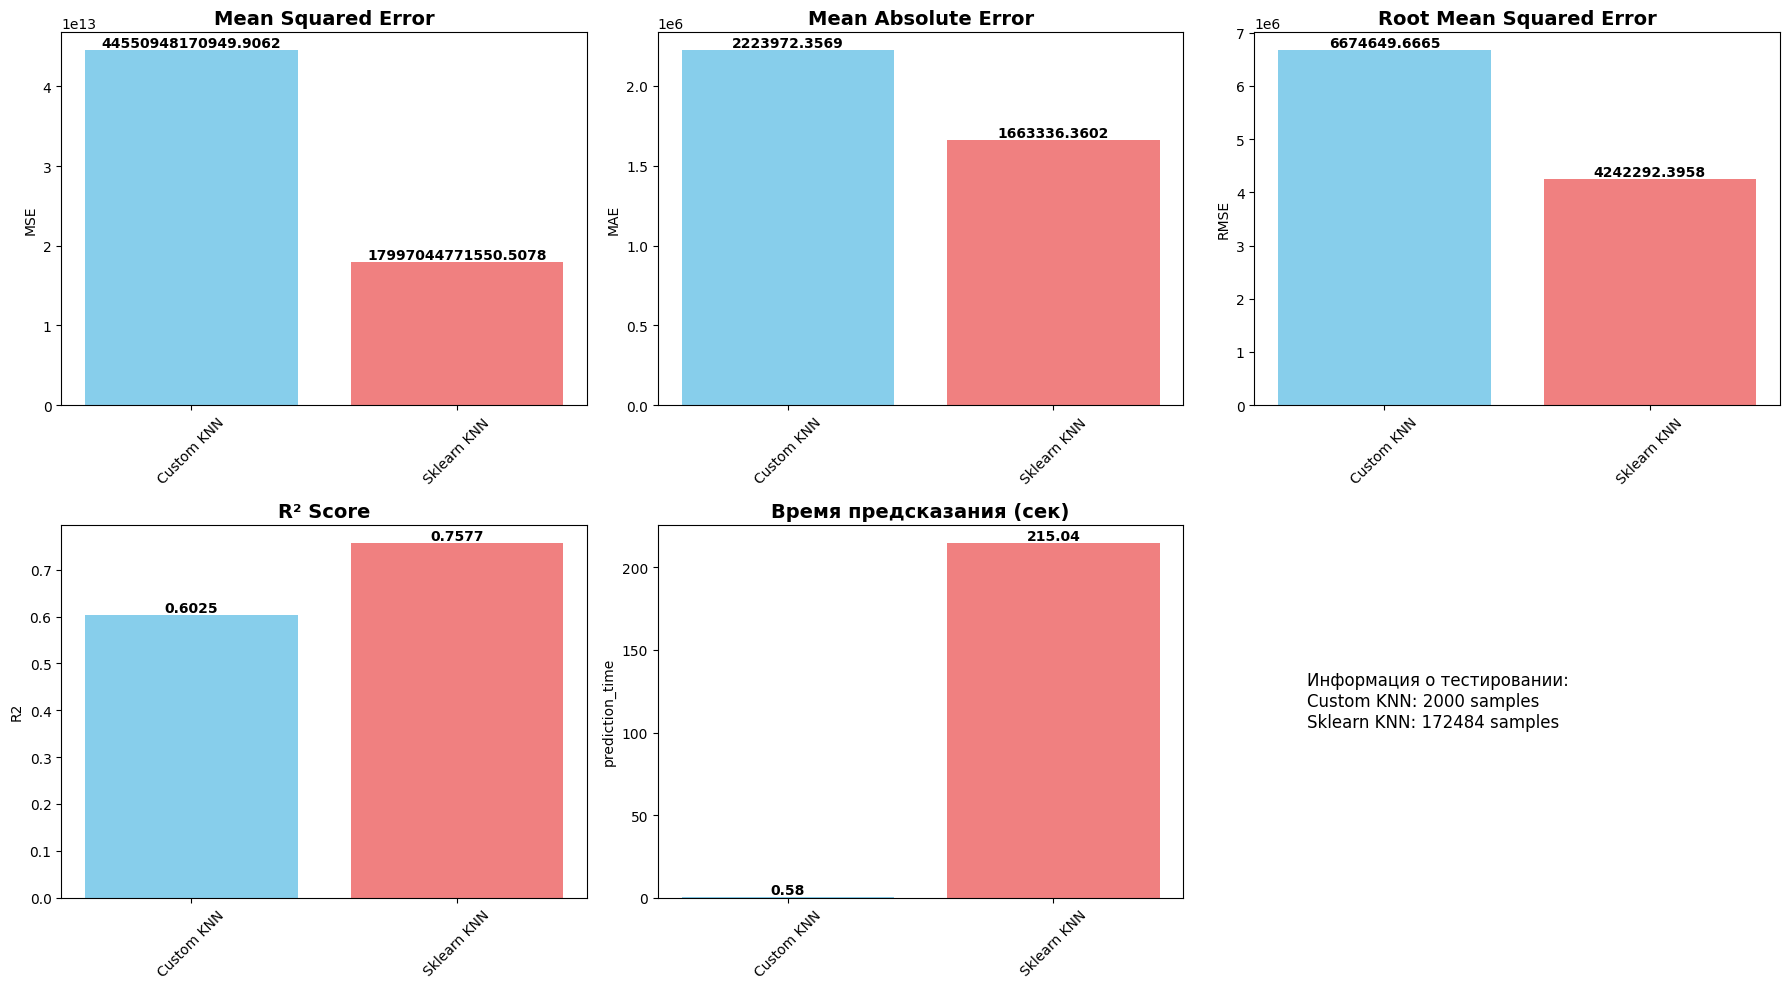


6. АНАЛИЗ РЕЗУЛЬТАТОВ
⚡ Производительность:
  Кастомная модель: 0.58 сек
  Sklearn модель:   215.04 сек
  Отношение скорости: 367.99x

🎯 Качество моделей (R²):
  Кастомная модель: 0.602542
  Sklearn модель:   0.757737
  Разница: 0.155195

🏆 Лучшая модель: Sklearn KNN
   Преимущество в R²: 0.155195

📊 Анализ ошибок:
  RMSE кастомной модели: 6674649.666533
  RMSE sklearn модели:   4242292.395810

ЭКСПЕРИМЕНТ ЗАВЕРШЕН!


In [43]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Наш кастомный KNNRegressor
class KNNRegressor:
    def __init__(self, n_neighbors=5, metric='euclidean', max_samples=5000):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.max_samples = max_samples
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        """Сохраняет обучающие данные с ограничением"""
        print("🔄 Обучение кастомного KNN...")
        start_time = time.time()
        
        # Ограничиваем количество обучающих данных
        if len(X) > self.max_samples:
            print(f"⚠️  Ограничение обучающих данных с {len(X)} до {self.max_samples} samples")
            X = X[:self.max_samples]
            y = y[:self.max_samples]
        
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        
        end_time = time.time()
        print(f"✅ Обучение завершено за {end_time - start_time:.2f} секунд")
        return self
    
    def predict(self, X, max_predict_samples=2000):
        """Предсказывает значения для X с ограничением"""
        print("🔄 Предсказание кастомным KNN...")
        start_time = time.time()
        
        X = np.array(X)
        
        # Ограничиваем количество данных для предсказания
        if len(X) > max_predict_samples:
            print(f"⚠️  Ограничение данных для предсказания с {len(X)} до {max_predict_samples} samples")
            X = X[:max_predict_samples]
        
        y_pred = []
        total_samples = len(X)
        
        for i, x in enumerate(X):
            # Вычисляем расстояния до всех тренировочных точек
            if self.metric == 'euclidean':
                distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            elif self.metric == 'manhattan':
                distances = np.sum(np.abs(self.X_train - x), axis=1)
            
            # Находим индексы k ближайших соседей
            neighbor_indices = np.argpartition(distances, self.n_neighbors)[:self.n_neighbors]
            
            # Предсказываем как среднее значение соседей
            prediction = np.mean(self.y_train[neighbor_indices])
            y_pred.append(prediction)
            
            # Прогресс каждые 25%
            if (i + 1) % max(1, total_samples // 4) == 0:
                elapsed = time.time() - start_time
                progress = (i + 1) / total_samples * 100
                print(f"📈 Прогресс: {i+1}/{total_samples} ({progress:.0f}%)")
        
        end_time = time.time()
        print(f"✅ Предсказание завершено за {end_time - start_time:.2f} секунд")
        return np.array(y_pred)

# Функция для оценки моделей
def evaluate_model(model, X_test, y_test, model_name, is_custom=True, max_test_samples=2000):
    """Вычисляет метрики качества модели"""
    print(f"\n📊 Оценка модели: {model_name}")
    
    # Ограничиваем тестовые данные для кастомной модели
    if is_custom and len(X_test) > max_test_samples:
        X_test_eval = X_test[:max_test_samples]
        y_test_eval = y_test[:max_test_samples]
        print(f"⚠️  Ограничение тестовых данных до {max_test_samples} samples")
    else:
        X_test_eval = X_test
        y_test_eval = y_test
    
    start_time = time.time()
    y_pred = model.predict(X_test_eval)
    prediction_time = time.time() - start_time
    
    # Вычисляем метрики
    mse = mean_squared_error(y_test_eval, y_pred)
    mae = mean_absolute_error(y_test_eval, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_eval, y_pred)
    
    print(f"✅ Оценка завершена за {prediction_time:.2f} секунд")
    
    return {
        'model': model_name,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'prediction_time': prediction_time,
        'samples_tested': len(X_test_eval)
    }

# Визуализация результатов
def plot_comparison(results_df):
    """Визуализация сравнения моделей"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    metrics = ['MSE', 'MAE', 'RMSE', 'R2', 'prediction_time']
    titles = ['Mean Squared Error', 'Mean Absolute Error', 'Root Mean Squared Error', 
              'R² Score', 'Время предсказания (сек)']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//3, i%3]
        bars = ax.bar(results_df['model'], results_df[metric], color=['skyblue', 'lightcoral'])
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        
        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}' if metric != 'prediction_time' else f'{height:.2f}',
                   ha='center', va='bottom', fontweight='bold')
    
    # Добавляем информацию о количестве samples
    ax_info = axes[1, 2]
    ax_info.axis('off')
    info_text = "Информация о тестировании:\n"
    for _, row in results_df.iterrows():
        info_text += f"{row['model']}: {row['samples_tested']} samples\n"
    ax_info.text(0.1, 0.5, info_text, fontsize=12, va='center')
    
    plt.tight_layout()
    plt.show()

# ОСНОВНОЙ ЭКСПЕРИМЕНТ
print("=" * 70)
print("ЭКСПЕРИМЕНТ: СРАВНЕНИЕ KNNRegressor С БИБЛИОТЕЧНЫМ АНАЛОГОМ")
print("=" * 70)

# Подготовка данных
print("\n1. ПОДГОТОВКА ДАННЫХ")
X = df_scalar.drop('price', axis=1)
y = df_scalar['price']

print(f"Размер исходного датасета: {X.shape}")

# Разделение на train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Масштабирование признаков (для честного сравнения)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n2. ОБУЧЕНИЕ МОДЕЛЕЙ")
print("-" * 50)

# Наша кастомная модель
print("🎯 Кастомный KNNRegressor")
knn_custom = KNNRegressor(n_neighbors=5, metric='euclidean', max_samples=5000)
knn_custom.fit(X_train_scaled, y_train)

# Библиотечная модель
print("\n🎯 Sklearn KNeighborsRegressor")
knn_sklearn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
knn_sklearn.fit(X_train_scaled, y_train)
print("✅ Обучение завершено")

print("\n3. ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ")
print("-" * 50)

results = []

# Оценка кастомной модели
results.append(evaluate_model(
    knn_custom, X_test_scaled, y_test, 
    "Custom KNN", is_custom=True, max_test_samples=2000
))

# Оценка библиотечной модели
results.append(evaluate_model(
    knn_sklearn, X_test_scaled, y_test, 
    "Sklearn KNN", is_custom=False
))

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

print("\n4. РЕЗУЛЬТАТЫ СРАВНЕНИЯ")
print("=" * 50)

# Выводим подробную таблицу результатов
print("\n📋 ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("=" * 70)
for _, row in results_df.iterrows():
    print(f"\n{row['model']}:")
    print(f"  MSE:  {row['MSE']:.6f}")
    print(f"  MAE:  {row['MAE']:.6f}")
    print(f"  RMSE: {row['RMSE']:.6f}")
    print(f"  R²:   {row['R2']:.6f}")
    print(f"  Время предсказания: {row['prediction_time']:.2f} сек")
    print(f"  Протестировано samples: {row['samples_tested']}")

# Визуализация
print("\n5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("-" * 50)
plot_comparison(results_df)

# Анализ лучшей модели
print("\n6. АНАЛИЗ РЕЗУЛЬТАТОВ")
print("=" * 50)

# Сравнение производительности
custom_time = results_df[results_df['model'] == 'Custom KNN']['prediction_time'].values[0]
sklearn_time = results_df[results_df['model'] == 'Sklearn KNN']['prediction_time'].values[0]

print(f"⚡ Производительность:")
print(f"  Кастомная модель: {custom_time:.2f} сек")
print(f"  Sklearn модель:   {sklearn_time:.2f} сек")
print(f"  Отношение скорости: {sklearn_time/custom_time:.2f}x")

# Сравнение качества
custom_r2 = results_df[results_df['model'] == 'Custom KNN']['R2'].values[0]
sklearn_r2 = results_df[results_df['model'] == 'Sklearn KNN']['R2'].values[0]

print(f"\n🎯 Качество моделей (R²):")
print(f"  Кастомная модель: {custom_r2:.6f}")
print(f"  Sklearn модель:   {sklearn_r2:.6f}")
print(f"  Разница: {abs(custom_r2 - sklearn_r2):.6f}")

# Определяем лучшую модель
if custom_r2 > sklearn_r2:
    best_model = "Custom KNN"
    advantage = custom_r2 - sklearn_r2
elif sklearn_r2 > custom_r2:
    best_model = "Sklearn KNN"
    advantage = sklearn_r2 - custom_r2
else:
    best_model = "Обе модели одинаковы"
    advantage = 0

print(f"\n🏆 Лучшая модель: {best_model}")
if advantage > 0:
    print(f"   Преимущество в R²: {advantage:.6f}")

# Дополнительный анализ ошибок
print(f"\n📊 Анализ ошибок:")
custom_rmse = results_df[results_df['model'] == 'Custom KNN']['RMSE'].values[0]
sklearn_rmse = results_df[results_df['model'] == 'Sklearn KNN']['RMSE'].values[0]

print(f"  RMSE кастомной модели: {custom_rmse:.6f}")
print(f"  RMSE sklearn модели:   {sklearn_rmse:.6f}")

print("\n" + "=" * 70)
print("ЭКСПЕРИМЕНТ ЗАВЕРШЕН!")
print("=" * 70)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Делим данные на обучающую и тестовую выборки
X = df_scalar.drop('price', axis=1)
y = df_scalar['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Масштабируем числовые признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели
# Собственная реализация LinearRegression
model_sgd = LinearRegression(learning_rate=0.01, optimization='SGD', max_iter=1000)
model_momentum = LinearRegression(learning_rate=0.01, optimization='Momentum', max_iter=1000)
model_adagrad = LinearRegression(learning_rate=0.1, optimization='AdaGrad', max_iter=1000)

model_sgd.fit(X_train_scaled, y_train)
model_momentum.fit(X_train_scaled, y_train)
model_adagrad.fit(X_train_scaled, y_train)

# Sklearn, берем из библиотеки, чтобы сверять с нашим
sk_model = SklearnLinearRegression()
sk_model.fit(X_train_scaled, y_train)

# Функция для расчёта метрик
def evaluate(y_true, y_pred, name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    print(f"\n{name}")
    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    return mse, mae, rmse

# Считаем ошибки
results = {}
results['SGD'] = evaluate(y_test, model_sgd.predict(X_test_scaled), "LinearRegression (SGD)")
results['Momentum'] = evaluate(y_test, model_momentum.predict(X_test_scaled), "LinearRegression (Momentum)")
results['AdaGrad'] = evaluate(y_test, model_adagrad.predict(X_test_scaled), "LinearRegression (AdaGrad)")
results['Sklearn'] = evaluate(y_test, sk_model.predict(X_test_scaled), "Sklearn LinearRegression")



LinearRegression (SGD)
MSE:  35968212669458.1172
MAE:  2627692.8184
RMSE: 5997350.4708

LinearRegression (Momentum)
MSE:  35962056809867.1016
MAE:  2631493.5167
RMSE: 5996837.2339

LinearRegression (AdaGrad)
MSE:  105794990076279.5156
MAE:  5613213.5454
RMSE: 10285669.1604

Sklearn LinearRegression
MSE:  35962056802843.2422
MAE:  2631493.5234
RMSE: 5996837.2333
